## Google Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Library

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms, models
from copy import deepcopy

from torchvision.datasets import ImageFolder
from sklearn import metrics

## Model

In [3]:
class ConvolutionBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    self.in_channels = in_channels
    self.out_channels = out_channels

    super().__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, (3, 3), padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, (3, 3), stride = 2, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
        )
  
  def forward(self, x):
    y = self.layers(x)
    return y

In [4]:
class ConvolutionalNeuralNet(nn.Module):
  def __init__(self, output_size):
    self.output_size = output_size

    super().__init__()

    self.blocks = nn.Sequential(
        ConvolutionBlock(3, 8),
        ConvolutionBlock(8, 16),
        ConvolutionBlock(16, 32),
        ConvolutionBlock(32, 64),
        ConvolutionBlock(64, 128),
        ConvolutionBlock(128, 256),
        ConvolutionBlock(256, 512),
        ConvolutionBlock(512, 1024))
    
    self.layers = nn.Sequential(
        nn.Linear(1024, 50),
        nn.ReLU(),
        nn.BatchNorm1d(50),
        nn.Linear(50, output_size),
        nn.Sigmoid())
  
  def forward(self, x):
    assert x.dim() > 2
    if x.dim() == 3:
      x = x.view(-1, 1, x.size(-2), x.size(-1))
    z = self.blocks(x)
    y = self.layers(z.squeeze())
    return y

## Hyper-parameter

In [5]:
config = {
    'train_ratio': 0.64,
    'validation_ratio': 0.16,
    'model': 'CNN',
    'batch_size': 256,
    'n_epochs': 10,
    'verbose': 1
}

## Utils

In [6]:
def get_loaders(config, input_size, is_train=True):
  train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),             
        transforms.ToTensor(),                           
    ])
  dataset = ImageFolder(root = '/content/drive/MyDrive/딥러닝 중간프로젝트/data', transform = train_transform)
  train_cnt = int(len(dataset)*config['train_ratio'])
  valid_cnt = int(len(dataset)*config['validation_ratio'])
  test_cnt = len(dataset) - train_cnt - valid_cnt
  train_dataset, valid_dataset, test_dataset,  = random_split(dataset, [train_cnt, valid_cnt, test_cnt])
  
  if is_train:
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),             
        transforms.ToTensor(),                           
    ])
  

    print("# of train_dataset : ", len(train_dataset))
    print("# of valid_dataset : ", len(valid_dataset))

    print(dataset.class_to_idx)

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=config['batch_size'])

    return train_loader, valid_loader
    
  else:
    test_transform = transforms.Compose([
        transforms.Resize((224,224)),                
        transforms.ToTensor(),                           
    ])

    
    print("# of test_dataset : ", len(test_dataset))

    #print(test_dataset.class_to_idx)

    test_loader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'])

    return test_loader

## Trainer

In [7]:
class Trainer():

  def __init__(self, model, optimizer, crit):
      self.model = model
      self.optimizer = optimizer
      self.crit = crit

      super().__init__()

  def _train(self, train_loader, config):
      self.model.train()

      total_loss = 0

      for i, (x_i, y_i) in enumerate(train_loader):
          y_hat_i = self.model(x_i)
          loss_i = self.crit(y_hat_i, y_i.squeeze())

          # Initialize the gradients of the model.
          self.optimizer.zero_grad()
          loss_i.backward()

          self.optimizer.step()
          
          if config['verbose'] >= 2:
              print("Train Iteration(%d/%d): loss=%.4e" % (i + 1, len(train_loader), float(loss_i)))

          # Don't forget to detach to prevent memory leak.
          total_loss += float(loss_i)

      return total_loss / len(train_loader)

  def _validate(self, valid_loader, config):
      # Turn evaluation mode on.
      self.model.eval()

      # Turn on the no_grad mode to make more efficintly.
      with torch.no_grad():
          total_loss = 0

          for i, (x_i, y_i) in enumerate(valid_loader):
              y_hat_i = self.model(x_i)
              loss_i = self.crit(y_hat_i, y_i.squeeze())
              
              if config['verbose'] >= 2:
                  print("Valid Iteration(%d/%d): loss=%.4e" % (i + 1, len(valid_loader), float(loss_i)))

              total_loss += float(loss_i)

          return total_loss / len(valid_loader)

  def train(self, train_loader, valid_loader, config):
      lowest_loss = np.inf
      best_model = None

      for epoch_index in range(config['n_epochs']):
          train_loss = self._train(train_loader, config)
          valid_loss = self._validate(valid_loader, config)

          # You must use deep copy to take a snapshot of current best weights.
          if valid_loss <= lowest_loss:
              lowest_loss = valid_loss
              best_model = deepcopy(self.model.state_dict())

          print("Epoch(%d/%d): train_loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e" % (
              epoch_index + 1,
              config['n_epochs'],
              train_loss,
              valid_loss,
              lowest_loss,
          ))

      # Restore to best model.
      self.model.load_state_dict(best_model)

## Train

In [8]:
def main(config):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  train_loader, valid_loader = get_loaders(config, input_size=224, is_train=True)

  
  model = ConvolutionalNeuralNet(2)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  crit = nn.CrossEntropyLoss()

  if config['verbose'] >= 1:
    print(model)
    print(optimizer)
    print(crit)

  trainer = Trainer(model, optimizer, crit)
  trainer.train(train_loader, valid_loader, config)

  # Save best model weights
  torch.save({
      'model': trainer.model.state_dict(),
      'opt': optimizer.state_dict(),
      'config': config,
  }, config['model'] + '.pth')

In [9]:
main(config)

# of train_dataset :  19301
# of valid_dataset :  4825
{'korean': 0, 'nonkorean': 1}
ConvolutionalNeuralNet(
  (blocks): Sequential(
    (0): ConvolutionBlock(
      (layers): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvolutionBlock(
      (layers): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_ru

## Test

In [10]:
model_fn = "./CNN.pth"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
def load(fn, device):
  d = torch.load(fn, map_location=device)
  
  return d['model'], d['config']

In [12]:
def confusion_matrix(y_test, y_pred):
  cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Precision:",metrics.precision_score(y_test, y_pred))
  print("Recall:",metrics.recall_score(y_test, y_pred))
  print("F1score:",metrics.f1_score(y_test, y_pred))

In [13]:
def test(model, test_loader):
  model.eval()
  
  total_cnt, correct_cnt = 0, 0
  y_test_li, y_pred_li = np.array([]), np.array([])
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      correct_cnt += (y.squeeze() == torch.argmax(y_hat, dim=-1)).sum()
      total_cnt += len(x)
      
      y_test_li = np.append(y_test_li, np.array(y.detach().cpu(), dtype='int'))
      y_pred_li = np.append(y_pred_li, np.array(torch.argmax(y_hat, dim=-1).detach().cpu(), dtype='int'))

    accuracy = correct_cnt / total_cnt
    print("Accuracy: %.4f" % accuracy)

    confusion_matrix(y_test_li, y_pred_li)

# of test_dataset :  6032
Accuracy: 0.9736
Accuracy: 0.9736405835543767
Precision: 0.9986653319986654
Recall: 0.9507623888182973
F1score: 0.974125305126119


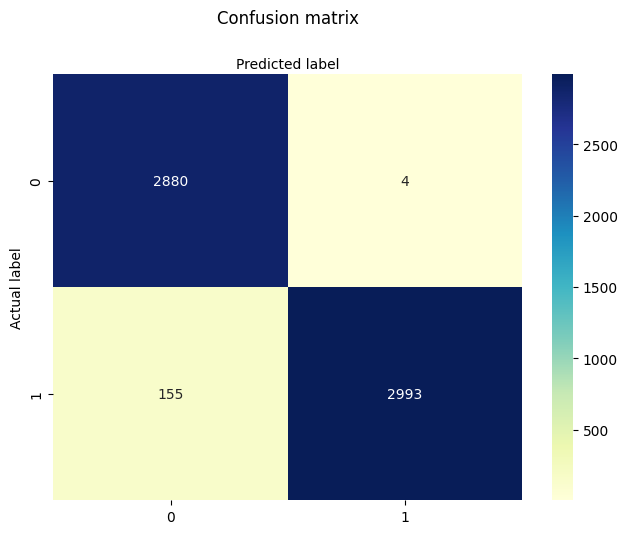

In [14]:
model_dict, train_config = load(model_fn, device)

test_loader = get_loaders(config, input_size=224, is_train=False)
model = ConvolutionalNeuralNet(2).to(device)
model.load_state_dict(model_dict)

test(model, test_loader)